# Group 96

In [1]:
#!pip install keras --upgrade
#!pip install tensorflow --upgrade
#!pip install imblearn


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters
from skimage import feature
from imblearn.under_sampling import RandomUnderSampler
from skimage import feature, draw
from skimage.transform import hough_circle, hough_circle_peaks
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint
import imblearn as imb
from sklearn.metrics import f1_score,precision_score, recall_score,accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import tensorflow as tf
from torch.utils.data import TensorDataset, DataLoader
from imblearn.over_sampling import RandomOverSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

2024-10-18 20:10:10.109168: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Import

In [2]:
X_train = np.load('Xtrain1.npy')
y_train = np.load('Ytrain1.npy')
X_test = np.load('Xtest1.npy')
X_train1_extra = np.load('Xtrain1_extra.npy')
# Size of the training set

print(X_train.shape) # 2700 images of size 48x48

# Hot Encoding the labels
train_labels = keras.utils.to_categorical(y_train,2)

(2783, 2304)


## Pre-Treatment

In [3]:
im = X_train.reshape(X_train.shape[0],48,48)    # Reshape the images to 48x48

new = im.copy() # Copy the images to a new array

threshold = 200
for sample in range(im.shape[0]):

  # Oustanding boundaries
  for i in range(im.shape[1]):
      for j in range(im.shape[2]):
          if (im[sample][i][j] > threshold) | (im[sample][i][j] < 50):
              new[sample][i][j] = 255
          else:
              new[sample][i][j] = 0

  # Removing isolated pixels
  for i in range(new.shape[1]):
      for j in range(new.shape[2]):
          if new[sample][i][j] == 255:
              if (i>0) and (j>0) and (i<new.shape[1]-1) and (j<new.shape[2]-1):
                  if ((new[sample][i-1][j]==0) and (new[sample][i+1][j]==0) and
                      (new[sample][i][j-1]==0) and (new[sample][i][j+1]==0) and
                      (new[sample][i-1][j-1]==0) and (new[sample][i-1][j+1]==0) and
                      (new[sample][i+1][j-1]==0) and (new[sample][i+1][j+1]==0)):

                        new[sample][i][j] = 0

In [4]:
#Flatten the images
X_train_processed = new.reshape(new.shape[0],48*48)

### Pre processing : X_extra

In [ ]:
im = X_train_extra.reshape(X_train_extra.shape[0],48,48)    # Reshape the images to 48x48

new = im.copy() # Copy the images to a new array

threshold = 200
for sample in range(im.shape[0]):

  # Oustanding boundaries
  for i in range(im.shape[1]):
      for j in range(im.shape[2]):
          if (im[sample][i][j] > threshold) | (im[sample][i][j] < 50):
              new[sample][i][j] = 255
          else:
              new[sample][i][j] = 0

  # Removing isolated pixels
  for i in range(new.shape[1]):
      for j in range(new.shape[2]):
          if new[sample][i][j] == 255:
              if (i>0) and (j>0) and (i<new.shape[1]-1) and (j<new.shape[2]-1):
                  if ((new[sample][i-1][j]==0) and (new[sample][i+1][j]==0) and
                      (new[sample][i][j-1]==0) and (new[sample][i][j+1]==0) and
                      (new[sample][i-1][j-1]==0) and (new[sample][i-1][j+1]==0) and
                      (new[sample][i+1][j-1]==0) and (new[sample][i+1][j+1]==0)):

                        new[sample][i][j] = 0

In [ ]:
#Flatten the images
X_extra_processed = new.reshape(new.shape[0],48*48)

## Data Imbalance

### The imbalance

In [5]:
print("The number of training samples with class 0 :", np.sum(y_train==0))
print("The number of training samples with class 1 :", np.sum(y_train==1))
print("The percentage of training samples with class 0 :", np.sum(y_train==0)/np.sum(y_train==1))

The number of training samples with class 0 : 1006
The number of training samples with class 1 : 1777
The percentage of training samples with class 0 : 0.566122678671919


### Random under-sampling

We remove randomly the saples from class 1 

In [6]:
#Random undersampling
rus = imb.under_sampling.RandomUnderSampler(sampling_strategy=np.sum(y_train==0)/np.sum(y_train==1))

X_train_RUS, y_train_RUS = rus.fit_resample(X_train_processed, y_train)
X_train_RUS, X_val_RUS, y_train_RUS, y_val_RUS = train_test_split(X_train_RUS,y_train_RUS, test_size=0.2)

# One hot encoding
train_labels_RUS = keras.utils.to_categorical(y_train_RUS,2)
val_labels_RUS = keras.utils.to_categorical(y_val_RUS,2)

### Random over-sampling

We randomly replicate data from class 0 to have the same amount as class 1.


IT CAN INCREASE OVERFITTING !!

In [7]:
ros = imb.over_sampling.RandomOverSampler(random_state=None)

X_train_ROS, y_train_ROS = ros.fit_resample(X_train_processed, y_train)
X_train_ROS, X_val_ROS, y_train_ROS, y_val_ROS = train_test_split(X_train_ROS, y_train_ROS, test_size=0.2)

# One hot encoding
train_labels_ROS = keras.utils.to_categorical(y_train_ROS,2)
val_labels_ROS = keras.utils.to_categorical(y_val_ROS,2)

print("The number of training samples with class 0 after ROS :", np.sum(y_train_ROS==0)+np.sum(y_val_ROS==0))
print("The number of training samples with class 1 after ROS :", np.sum(y_train_ROS==1)+np.sum(y_val_ROS==1))

The number of training samples with class 0 after ROS : 1777
The number of training samples with class 1 after ROS : 1777


### Modified SMOTE

We randomly choose a subset of the minority class and we randomly create new samples. 

We use a modified version because SMOTE is not effective on high dimensional datasets.

In [39]:
# Modified SMOTE : MSMOTE


## Machine Learning

### Neural Network

In [8]:
# Définir le callback EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',   # The quantity to be monitored
    patience=20,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # restore the best model
    mode='min',           # consider the quantity to be monitored as minimum
    verbose=1             # a message will be printed
)

batch_size=50
epochs=50
lr=0.001

#### Creating the Model for RUS

The size of input layer is : $48*48$ 

The number of hidden layers is between 2 and 5: giving the number of samples. 
2 if under 10 000 samples.

Epoch 1/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6141 - loss: 8.3978 - val_accuracy: 0.6984 - val_loss: 2.1835
Epoch 2/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9221 - loss: 0.8363 - val_accuracy: 0.7307 - val_loss: 1.8069
Epoch 3/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9714 - loss: 0.2814 - val_accuracy: 0.7469 - val_loss: 1.8934
Epoch 4/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9955 - loss: 0.1125 - val_accuracy: 0.7720 - val_loss: 1.8781
Epoch 5/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9942 - loss: 0.1371 - val_accuracy: 0.7594 - val_loss: 1.7567
Epoch 6/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 0.0356 - val_accuracy: 0.7487 - val_loss: 1.9132
Epoch 7/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9846 - loss: 0.1606 - val_accuracy: 0.7415 - val_loss: 2.3080
Epoch 8/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9913 - loss: 0.1270 - val_accuracy: 0.

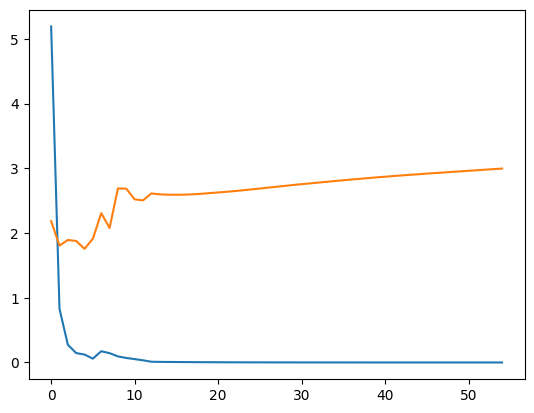

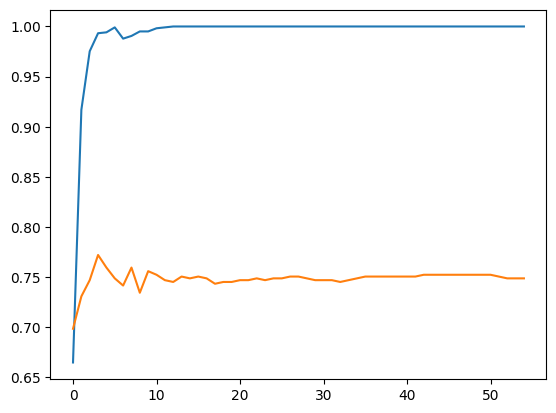

([<matplotlib.lines.Line2D at 0x7f94a2038b50>], None)

In [60]:
sgd = keras.optimizers.SGD(learning_rate = lr)
model_RUS.compile(optimizer = sgd,
              loss = 'binary_crossentropy',
              metrics=['accuracy'])


#MLP with early stopping
history_RUS = model_RUS.fit(x = X_train_RUS,
                    y=train_labels_RUS,
                    epochs = epochs,
                    batch_size=batch_size,
                    validation_data = (X_val_RUS,val_labels_RUS),
                    callbacks = [early_stopping],
                    verbose = 1)


####PLOT EVOLUTION
plt.figure(1)
plt.clf()
plt.plot(history_RUS.history['loss'], label='train'),
plt.plot(history_RUS.history['val_loss'], label='validation'), plt.show()
plt.plot(history_RUS.history['accuracy'], label='train'),
plt.plot(history_RUS.history['val_accuracy'], label='validation'), plt.show()



#### Creating the Model for ROS

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 1024)           │     2,360,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,057,730 (11.66 MB)

 Trainable params: 3,057,730 (11.66 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5750 - loss: 3.0588 - val_accuracy: 0.6160 - val_loss: 1.5444
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8122 - loss: 0.5852 - val_accuracy: 0.6934 - val_loss: 1.0968
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9159 - loss: 0.2728 - val_accuracy: 0.7314 - val_loss: 1.0654
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9592 - loss: 0.1739 - val_accuracy: 0.7468 - val_loss: 1.0763
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9838 - loss: 0.1427 - val_accuracy: 0.7581 - val_loss: 1.0771
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9869 - loss: 0.1223 - val_accuracy: 0.7595 - val_loss: 1.0680
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9901 - loss: 0.1072 - val_accuracy: 0.7581 - val_loss: 1.1008
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9924 - loss: 0.0904 - val_accuracy: 0.7609 - v

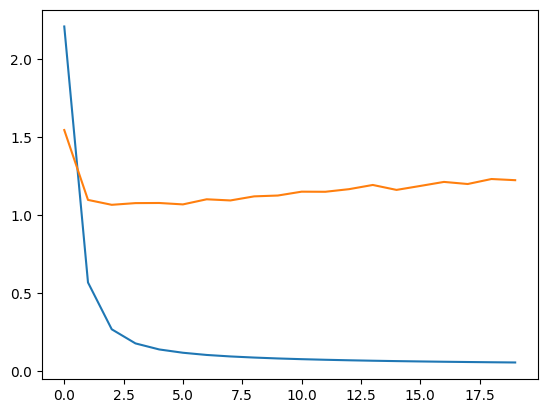

([<matplotlib.lines.Line2D at 0x7f9627aa9550>], None)

In [16]:
# Neural network
model_ROS = Sequential()

#0.95 with  256 -> 128 -> 64 -> 2
#0.88 with 128 -> 64 -> 32 -> 2
#0.81 with 128 -> 64 -> 32 -> 16 -> 2
#0.86 with 256 -> 128 -> 64 -> 32 -> 2


# Input layer
model_ROS.add(Dense(1024, input_shape=(48*48,), activation='relu')) 
model_ROS.add(Dense(512, activation='relu'))
model_ROS.add(Dense((256), activation='relu'))
model_ROS.add(Dense((128), activation='relu'))
model_ROS.add(Dense((64), activation='relu')) 
model_ROS.add(Dense(2, activation='sigmoid'))
model_ROS.summary()

sgd = keras.optimizers.SGD(learning_rate = lr)
model_ROS.compile(optimizer = sgd,
              loss = 'binary_crossentropy',
              metrics=['accuracy'])


#MLP with early stopping
history = model_ROS.fit(x = X_train_ROS,
                    y=train_labels_ROS,
                    epochs = epochs,
                    batch_size=batch_size,
                    validation_data = (X_val_ROS,val_labels_ROS),
                    callbacks = [early_stopping],
                    verbose = 1)


####PLOT EVOLUTION
plt.figure(1)
plt.clf()
plt.plot(history.history['loss'], label='train'),
plt.plot(history.history['val_loss'], label='train'), plt.show()


#### Predictions on X_extra

We can use X_extra and do prediction on it and then combine X_train and X_extra

In [12]:
# Predictions
y_pred = model_ROS.predict(X_extra_processed)
# indexes of class 0 with probability > 0.8 
indexes = np.where(y_pred[:,0]>0.8)

# From indexes
y_pred_0 = y_pred[indexes]
y_pred_0 = np.argmax(y_pred_0, axis=1)

print("The number of extra samples with class 0 :", len(indexes[0]))
print("The number of extra samples with class 1 :", len(y_pred)-len(indexes[0]))

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
The number of extra samples with class 0 : 175
The number of extra samples with class 1 : 729


#### Adding X_extra to set for training

In [13]:

X_train_combined, X_val_combined, y_train_combined, y_val_combined = train_test_split(X_train, y_train, test_size=0.2)
train_labels_combined = keras.utils.to_categorical(y_train_combined,2)
val_labels_combined = keras.utils.to_categorical(y_val_combined,2)

# Adding the extra samples to the training set for class 0
print(y_pred_0.shape)
print(y_train_combined.shape)
X_train_combined = np.concatenate((X_train_combined,X_extra_processed[indexes]),axis=0)
y_train_combined = np.concatenate((y_train_combined,y_pred_0),axis=0)


# ROS
ros = imb.over_sampling.RandomOverSampler(random_state=None)
X_train_ROS_combined, y_train_ROS_combined = ros.fit_resample(X_train_combined, y_train_combined)
train_labels_ROS_combined = keras.utils.to_categorical(y_train_ROS_combined,2)

print("The number of training samples with class 0 after adding extra samples :", np.sum(y_train_combined==0))
print("The number of training samples with class 1 after adding extra samples :", np.sum(y_train_combined==1))

(175,)
(2226,)
The number of training samples with class 0 after adding extra samples : 947
The number of training samples with class 1 after adding extra samples : 1454


#### Training with X_extra

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5300 - loss: 125.5091 - val_accuracy: 0.5817 - val_loss: 0.7293
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.6355 - loss: 0.6832 - val_accuracy: 0.6409 - val_loss: 0.6725
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.6667 - loss: 0.6247 - val_accuracy: 0.6086 - val_loss: 0.6868
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.6474 - loss: 0.5967 - val_accuracy: 0.4506 - val_loss: 0.7864
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.6617 - loss: 0.5931 - val_accuracy: 0.5745 - val_loss: 0.6887
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.6794 - loss: 0.5869 - val_accuracy: 0.5655 - val_loss: 0.7106
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6707 - loss: 0.5831 - val_accuracy: 0.6194 - val_loss: 0.6865
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6762 - loss: 0.5784 - val_accuracy: 0.6104 -

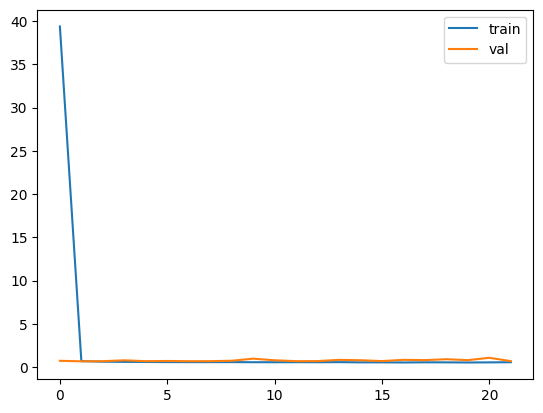

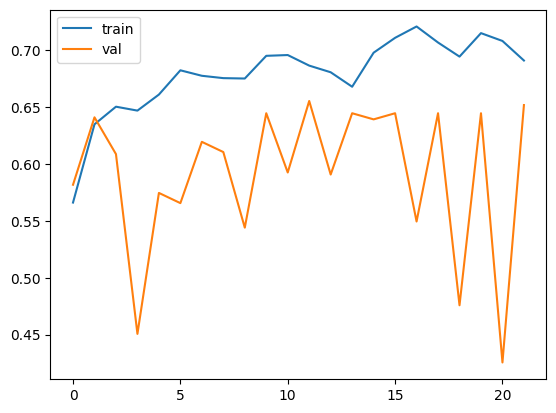

(<matplotlib.legend.Legend at 0x7f9627ace910>, None)

In [15]:
sgd = keras.optimizers.SGD(learning_rate = lr)
model_ROS.compile(optimizer = sgd,
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

#MLP without early stopping
history = model_ROS.fit(x = X_train_ROS_combined,
                    y=train_labels_ROS_combined,
                    epochs = epochs,
                    batch_size=batch_size,
                    validation_data = (X_val_combined,val_labels_combined),
                    callbacks = [early_stopping],
                    verbose = 1)

####PLOT EVOLUTION
plt.figure(1)
plt.clf()
plt.plot(history.history['loss'], label='train'),
plt.plot(history.history['val_loss'], label='val'), 
plt.legend(),plt.show()
plt.plot(history.history['accuracy'], label='train'),
plt.plot(history.history['val_accuracy'], label='val'),
plt.legend(),plt.show()


#### K-fold

In [ ]:

# Cross validation with keras and scikit-learn f1 score on validation set
from sklearn.model_selection import StratifiedKFold

# Define the K-fold Cross Validator
kfold = StratifiedKFold(n_splits=10, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
f1 = []
print(X_train_ROS_combined.shape)
print(y_train_ROS_combined.shape)
for train, test in kfold.split(X_train_ROS_combined, y_train_ROS_combined):
  # Validation set

  model = Sequential()
  model.add(Dense(256, input_shape=(48*48,), activation='relu')) 
  model.add(Dense(128, activation='relu'))
  model.add(Dense((64), activation='relu'))
  model.add(Dense(2, activation='sigmoid'))

  adam = keras.optimizers.Adam(learning_rate = lr)
  model.compile(optimizer = adam,
                loss = ['binary_crossentropy'],
                metrics=['accuracy'])

  # Fit data to model
  history = model.fit(X_train_ROS_combined[train], train_labels_ROS_combined[train],
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(X_train_ROS_combined[test], train_labels_ROS_combined[test]),
                      callbacks = [early_stopping]
                      )

  # Generate generalization metrics on validation set
  scores = model.evaluate(X_train_ROS_combined[test], train_labels_ROS_combined[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  f1.append(f1_score(np.argmax(train_labels_ROS_combined[test],axis=1),np.argmax(model.predict(X_train_ROS_combined[test]),axis=1)))
  fold_no += 1



In [98]:
print(f1)

[0.7361963190184051, 0.6904761904761905, 0.7811447811447811, 0.7019867549668874, 0.7499999999999999, 0.7019867549668873, 0.6956521739130436, 0.7752442996742671, 0.711864406779661, 0.6614785992217899]


### Random Forest

In [ ]:
# Random Forest
clf = RandomForestClassifier(n_estimators=500, max_depth=15, random_state=0)
clf.fit(X_train_ROS, y_train_ROS)
y_pred = clf.predict(X_val_ROS)
print("Random Forest accuracy: ", accuracy_score(y_val_ROS, y_pred))
print("Random Forest F1 score: ", f1_score(y_val_ROS, y_pred))
print("Random Forest confusion matrix: \n", confusion_matrix(y_val_ROS, y_pred))

#### Random Search

In [ ]:
# Define hyperparameter distributions
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)],  # Number of trees
    'max_features': ['auto', 'sqrt'],  # Number of features to consider for best split
    'max_depth': [int(x) for x in np.linspace(10, 200, num=11)],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required at each leaf node
    'bootstrap': [True, False]  # Whether bootstrap samples are used when building trees
}

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings that are sampled
    cv=5,  # Number of cross-validation folds
    verbose=3,
    scoring="accuracy",
    random_state=42,
    n_jobs=-1  # Use all available processors

In [ ]:
# Fit the RandomizedSearchCV instance
random_search.fit(X_train, y_train)

# Retrieve the best parameters found by RandomizedSearchCV
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# Evaluate the model with best parameters on the test set
best_estimator = random_search.best_estimator_
test_accuracy = best_estimator.score(X_val_ROS, y_val_ROS)
print("Test Accuracy with Best Parameters:", test_accuracy)

In [ ]:
y_pred_val = best_estimator.predict_proba(X_val_ROS)
y_pred = np.argmax(y_pred_val,1)
print("Random Forest accuracy: ", accuracy_score(y_val_ROS, y_pred))
print("Random Forest F1 score: ", f1_score(y_val_ROS, y_pred))


cm = confusion_matrix(y_val_ROS, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_estimator.classes_)

disp.plot()
plt.show()

#### Grid Search

In [ ]:
rf_grid = RandomForestClassifier()
gr_space = {
    'max_depth': [50, 100, 150, 200],
    'n_estimators': [300,500,750,1000,1500,2000],
}

grid = GridSearchCV(rf_grid, gr_space, cv = 3, scoring='accuracy', verbose = 3)
model_grid = grid.fit(X_train_ROS, y_train_ROS)

print('Best hyperparameters are '+str(model_grid.best_params_))
print('Best score is: ' + str(model_grid.best_score_))

#### Predictions on X_extra

In [ ]:
# Prediction on X_extra
y_pred_extra = best_estimator.predict_proba(X_extra_processed)

indexes = np.where(y_pred_extra[:,0]>0.999)[0]

y_pred_extra = np.argmax(y_pred_extra[indexes],1)


#### Adding X_extra to the training set


In [ ]:
ros = imb.over_sampling.RandomOverSampler(random_state=None)

X_train_combined, X_val_combined, y_combined, y_val_combined = train_test_split(X_train, y_train, test_size=0.2)

X_combined_ROS, y_combined_ROS = ros.fit_resample(X_train_combined, y_combined)

X_combined_ROS = np.concatenate((X_combined_ROS, X_extra_processed[indexes]), axis=0)
y_combined_ROS = np.concatenate((y_combined_ROS, y_pred_extra), axis=0)

# One hot encoding
train_labels_ROS = keras.utils.to_categorical(y_combined_ROS,2)
val_labels_ROS = keras.utils.to_categorical(y_val_ROS,2)

print("The number of training samples with class 0 after ROS :", np.sum(y_combined_ROS==0)+np.sum(y_val_combined==0))
print("The number of training samples with class 1 after ROS :", np.sum(y_combined_ROS==1)+np.sum(y_val_combined==1))

#### Training

In [17]:
# Training clf_rs
best_estimator.fit(X_combined_ROS, y_combined_ROS)

NameError: name 'clf_rs' is not defined

In [ ]:
# Metrics
cf_mat = confusion_matrix(y_val_combined, best_estimator.predict(X_val_combined))
print("Random Forest accuracy: ", accuracy_score(y_val_combined, best_estimator.predict(X_val_combined)))
print(cf_mat)

### Convutional NN : AlexNet

#### Preparing the data to be used in the neural tetwork:

In [ ]:
X_train_valanced = X_train_ROS.reshape(X_train_ROS.shape[0],48,48)
X_val_valanced = X_val.reshape(X_val.shape[0],48,48)

X_train_normalized = (X_train_valanced / 255.0).astype(np.float32)  # Tensors only admit normalized float data
X_val_normalized = (X_val_valanced / 255.0).astype(np.float32)

X_train_tensor = torch.tensor(X_train_normalized, dtype=torch.float32)
X_train_tensor = X_train_tensor.unsqueeze(1)  # We add a dimension to be used in the neural network
X_val_tensor = torch.tensor(X_val_normalized, dtype=torch.float32)
X_val_tensor = X_val_tensor.unsqueeze(1)

y_train_tensor = torch.tensor(y_train_ROS, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False) # To have the same referenc at any epoch

#### Definition of the Net

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
         # Layers creation
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2) #Padding = kernel_size//2
        self.mp1 = nn.MaxPool2d(2) # Reduces the dimensions of the layer by getting the important value
        self.conv2 = nn.Conv2d(6, 18, 5, padding=2)
        self.mp2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(18, 126, 3, padding=1)
        self.fc1 = nn.Linear(12*12*126, 256) # Reduces the dimension of the features
        self.fc2 = nn.Linear(256, 2) # Output layer

    def forward(self, x):
       # Backpropagation of the error
        x = F.relu(self.conv1(x)) # Activation funtion
        x = self.mp1(x)
        x = F.relu(self.conv2(x))
        x = self.mp2(x)
        x = F.relu(self.conv3(x))
        x = x.view(-1, 12*12*126)
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x)) # Activation funtion at the output
        return x

#### Loss Function and Optimizer

In [18]:
model = LeNet()
criterion = nn.CrossEntropyLoss() # Loss funtion
#optimizer = optim.Adam(model.parameters(), lr=0.01) #Learning rate and momentum, adam decreases automatically the lr
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) #Learning rate and momentum
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)
#scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, threshold=0.0001, verbose=True)

model

NameError: name 'LeNet' is not defined

#### Training

In [ ]:
n_epochs = 60

train_accuracy = torch.zeros(n_epochs)
train_loss = torch.zeros(n_epochs)
val_accuracy = torch.zeros(n_epochs)
val_loss = torch.zeros(n_epochs)


for epoch in range(n_epochs):

    # Train
    print("Epoch ",epoch)
    model.train()
    running_loss = 0.0 # Loss of each epoch
    running_acc = 0.0 # Accuracy of each epoch
    total = 0
    for i, (images, labels) in enumerate(train_loader, 0):
        total += labels.shape[0]
        # Gradients inicialization
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images) # Forward-pass
        loss = criterion(outputs, labels) # Loss computing
        loss.backward()# Backward pass
        optimizer.step() # Optimization

        # Estatistics
        running_loss += loss.item() # Total loss of the current batch
        # extraemos las etiquetas que predice (nº neurona con máxima probabilidad)
        _, predicted = torch.max(outputs, 1)
        running_acc += torch.sum(predicted==labels) # Number of correct predictions
    train_accuracy[epoch] = running_acc/total
    train_loss[epoch] = running_loss/total
    print(f'Train      >>> Epoch {epoch} >>>>   Train Loss: {running_loss/total}, Train Acc: {running_acc/total}')

    # Validation
    model.eval()  # modo evaluación, desactiva dropout, batchnorm, etc.
    running_val_loss = 0.0  # # Loss of each epoch
    running_val_acc = 0.0  # Accuracy of each epoch
    total_val = 0

    with torch.no_grad():  # Gradient desactivation for validation
        for i, (images, labels) in enumerate(val_loader, 0):
            total_val += labels.shape[0]

            outputs = model(images)  # forward-pass
            loss = criterion(outputs, labels)  # Loss computing

            running_val_loss += loss.item()  # Total loss of the current batch
            _, predicted = torch.max(outputs, 1)  # Predictions
            running_val_acc += torch.sum(predicted == labels)  # Number of correct predictions

    val_accuracy[epoch] = running_val_acc/total_val  # Validation accuracy
    val_loss[epoch] = running_val_loss/total_val
    print(f'Validation >>> Epoch {epoch} >>>>   Val Loss:   {running_val_loss/total_val}, Val Acc:   {running_val_acc/total_val}')

    current_lr = optimizer.param_groups[0]['lr']  # Learning rate of the epoch
    print(f'Current learning rate: {current_lr:.6f}')
    print()
    scheduler.step()  # Step reduction every "step size" epochs


# F1 score
outputs = model(X_val_tensor)
_, y_predicted = torch.max(outputs, 1) # obtención de etiquetas numéricas
f1 = f1_score(y_val_tensor, y_predicted, average='macro')
print('F1: %.3f' % f1)
print()


#figure, ax2, = plt.subplotss
plt.plot(range(n_epochs), train_accuracy, label='Training')
plt.plot(range(n_epochs), val_accuracy, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(loc='best')
plt.grid(True)
plt.show()

plt.plot(range(n_epochs), train_loss, label='Training')
plt.plot(range(n_epochs), val_loss, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss (%)')
plt.legend(loc='best')
plt.grid(True)
plt.show()

#### X_extra transformation

In [19]:


X_extra_normalized = (X_extra_processed / 255.0).astype(np.float32)  # Tensors only admit normalized float data

X_extra_tensor = torch.tensor(X_extra_normalized, dtype=torch.float32)
X_extra_tensor = X_extra_tensor.unsqueeze(1)  # We add a dimension to be used in the neural network


NameError: name 'X_extra_processed' is not defined

#### Predictions on X_extra

In [ ]:
# Data prediction
outputs = model(X_extra_tensor)
_, y_predicted = torch.max(outputs, 1)
indexes = np.where(outputs[:,0]>0.975)
print('Number of samples in the extra set: ', outputs.shape[0])
print('Number of samples whose probability to belong to class "0" is high: ', len(indexes[0]))

#### Adding to training Set

In [ ]:
X_train_combined, X_val, y_train_combined, y_val = train_test_split(X_train_processed, y_train, test_size=0.2)

X_extra_processed = X_extra_processed.reshape(X_extra_processed.shape[0],48*48)

X_train_combined = np.concatenate((X_train_combined,X_extra_processed[indexes]),axis=0)
y_train_combined = np.concatenate((y_train_combined,y_predicted[indexes]),axis=0)

print("The number of training samples with class 0 before ROS:", np.sum(y_train_combined==0))
print("The number of training samples with class 1 before ROS:", np.sum(y_train_combined==1))

In [ ]:
ros = imb.over_sampling.RandomOverSampler(random_state=None)
X_combined_ROS, y_combined_ROS = ros.fit_resample(X_train_combined, y_train_combined)
print("The number of training samples with class 0 after ROS :", np.sum(y_combined_ROS==0))
print("The number of training samples with class 1 after ROS :", np.sum(y_combined_ROS==1))

#### Adaptation for Training with X_extra

In [ ]:
X_combined_valanced_train = X_combined_ROS.reshape(X_combined_ROS.shape[0],48,48)
X_combined_valanced_val = X_val.reshape(X_val.shape[0],48,48)


X_combined_normalized_train = (X_combined_valanced_train / 255.0).astype(np.float32)  # Tensors only admit normalized float data
X_combined_normalized_val = (X_combined_valanced_val / 255.0).astype(np.float32)  # Tensors only admit normalized float data

X_combined_tensor_train = torch.tensor(X_combined_normalized_train, dtype=torch.float32)
X_combined_tensor_val = torch.tensor(X_combined_normalized_val, dtype=torch.float32)

X_combined_tensor_train = X_combined_tensor_train.unsqueeze(1)  # We add a dimension to be used in the neural network
X_combined_tensor_val = X_combined_tensor_val.unsqueeze(1)  # We add a dimension to be used in the neural network

y_combined_tensor_train = torch.tensor(y_combined_ROS, dtype=torch.long)
y_combined_tensor_val = torch.tensor(y_val, dtype=torch.long)

combined_train_dataset = TensorDataset(X_combined_tensor_train, y_combined_tensor_train)
combined_val_dataset = TensorDataset(X_combined_tensor_val, y_combined_tensor_val)

combined_train_loader = DataLoader(dataset=combined_train_dataset, batch_size=64, shuffle=True)
combined_val_loader = DataLoader(dataset=combined_val_dataset, batch_size=64, shuffle=False)

#### Training with X_extra

In [ ]:
n_epochs = 20

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) #we need to dedine the optimizer again
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

train_accuracy = torch.zeros(n_epochs)
val_accuracy = torch.zeros(n_epochs)
train_loss = torch.zeros(n_epochs)
val_loss = torch.zeros(n_epochs)


for epoch in range(n_epochs):

    # Train
    print("Epoch ",epoch)
    model.train()
    running_train_loss = 0.0 # Loss of each epoch
    running_train_acc = 0.0 # Accuracy of each epoch
    total = 0
    for i, (images, labels) in enumerate(combined_train_loader, 0):
        total += labels.shape[0]
        # Gradients inicialization
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images) # Forward-pass
        loss = criterion(outputs, labels) # Loss computing
        loss.backward()# Backward pass
        optimizer.step() # Optimization

        # Estatistics
        running_train_loss += loss.item() # Total loss of the current batch
        # extraemos las etiquetas que predice (nº neurona con máxima probabilidad)
        _, predicted = torch.max(outputs, 1)
        running_train_acc += torch.sum(predicted==labels) # Number of correct predictions

    train_accuracy[epoch]=running_train_acc/total
    train_loss[epoch]=running_train_loss/total
    print(f'Train      >>> Epoch {epoch} >>>>   Train Loss: {running_train_loss/total/total}, Train Acc: {running_train_acc/total}')

    # Validation
    model.eval()  # modo evaluación, desactiva dropout, batchnorm, etc.
    running_val_loss = 0.0  # # Loss of each epoch
    running_val_acc = 0.0  # Accuracy of each epoch
    total_val = 0

    with torch.no_grad():  # Gradient desactivation for validation
        for i, (images, labels) in enumerate(combined_val_loader, 0):
            total_val += labels.shape[0]

            outputs = model(images)  # forward-pass
            loss = criterion(outputs, labels)  # Loss computing

            running_val_loss += loss.item()  # Total loss of the current batch
            _, predicted = torch.max(outputs, 1)  # Predictions
            running_val_acc += torch.sum(predicted == labels)  # Number of correct predictions

    val_accuracy[epoch]=running_val_acc/total_val  # Validation accuracy
    val_loss[epoch]=running_val_loss/total
    print(f'Validation >>> Epoch {epoch} >>>>   Val Loss:   {running_val_loss/total_val}, Val Acc:   {running_val_acc/total_val}')

    current_lr = optimizer.param_groups[0]['lr']  # Learning rate of the epoch
    print(f'Current learning rate: {current_lr:.6f}')
    print()
    scheduler.step()  # Step reduction every "step size" epochs


plt.plot(range(n_epochs), train_accuracy, label='Training')
plt.plot(range(n_epochs), val_accuracy, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend(loc='best')
plt.grid(True)
plt.show()


plt.plot(range(n_epochs), train_loss, label='Training')
plt.plot(range(n_epochs), val_loss, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss (%)')
plt.legend(loc='best')
plt.grid(True)
plt.show()

#### Confusion Matrix

In [ ]:
outputs = model(X_combined_tensor_val)
_, y_combined_predicted = torch.max(outputs, 1) # obtención de etiquetas numéricas

con_matrix = confusion_matrix(y_true=y_combined_tensor_val, y_pred=y_combined_predicted)

fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(con_matrix, cmap=plt.cm.Greens, alpha=0.4)


for i in range(con_matrix.shape[0]):
    for j in range(con_matrix.shape[1]):
        ax.text(x=j, y=i,
                s=con_matrix[i, j],
                va='center', ha='center')

plt.xlabel('Predicted class')
plt.ylabel('Real class')
plt.show()


# F1 score
f1 = f1_score(y_combined_tensor_val, y_combined_predicted, average='macro')
print('F1: %.3f' % f1)
print()

## Predictions on the test set

In [ ]:
im = X_test.reshape(X_test.shape[0],48,48)

new = im.copy()

threshold = 200
for sample in range(im.shape[0]):

  # Oustanding boundaries
  for i in range(im.shape[1]):
      for j in range(im.shape[2]):
          if (im[sample][i][j] > threshold) | (im[sample][i][j] < 50):
              new[sample][i][j] = 255
          else:
              new[sample][i][j] = 0

  # Removing isolated pixels
  for i in range(new.shape[1]):
      for j in range(new.shape[2]):
          if new[sample][i][j] == 255:
              if (i>0) and (j>0) and (i<new.shape[1]-1) and (j<new.shape[2]-1):
                  if ((new[sample][i-1][j]==0) and (new[sample][i+1][j]==0) and
                      (new[sample][i][j-1]==0) and (new[sample][i][j+1]==0) and
                      (new[sample][i-1][j-1]==0) and (new[sample][i-1][j+1]==0) and
                      (new[sample][i+1][j-1]==0) and (new[sample][i+1][j+1]==0)):

                        new[sample][i][j] = 0

In [ ]:
X_test_processed = new.copy()

X_test_normalized = (X_test_processed / 255.0).astype(np.float32)  # Tensors only admit normalized float data

X_test_tensor = torch.tensor(X_test_normalized, dtype=torch.float32)
X_test_tensor = X_test_tensor.unsqueeze(1)  # We add a dimension to be used in the neural network

In [ ]:
outputs = model(X_extra_tensor)
_, y_test_tensor = torch.max(outputs, 1)

In [ ]:
y_test_np = y_test_tensor.numpy()
np.save('y_test', y_test_np)